<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-Garethlomax/blob/data_curation/dataset_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS
We are constructing using the functions in the accompanying .py files as computer doesnt have enough ram to handle full dataset.


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
import h5py
import random

# FUNCTIONS

In [3]:
def date_to_int_list(date):
    # date is in format yyyy-mm-dd

    y = int(date[0:4])
    m = int(date[5:7])
    d = int(date[8:10])

#    print("date is:")
#    print(y, " ",m, " ", d)
    return [y,m,d]

def monotonic_date(date, baseline = [1989, 1, 1]):

    date = date_to_int_list(date)
#    print(type(date[0]))
#    print(type(baseline[0]))
    # turns date since baseline start date into a monotonic function based on
    # year and months in line with pgm unit of analysis
    return date[1] - baseline[1] + ((date[0] - baseline[0]) * 12)



def construct_layer(dataframe, key, prio_key = "gid", debug = False):
    # returns 360 720 grid layer for a given parameter
    # should be given for one parameter per year.
    array = np.zeros(360*720)
    prio_grid = dataframe[prio_key]
    for i in range(len(prio_grid)):
        j = prio_grid.iloc[i] - 1
        """change the below to only be in the case it isnt nan""" # will this cause problems?
        array[j] += dataframe[key].iloc[i]
    array.resize(360,720)

    return array

def construct_combined_sequence(dataframe_prio, dataframe_ucdp, key_list_prio, key_list_ucdp, string_start, start = [1989, 1,1], stop = [2014,1,1]):
    """commented out the stop and start"""
    #stop  = '2014-01-01'
    # need to adapt ged and other year / month vs ged database for this.
    # bool prio to add multiples of 12 to each year usin prio grid.
    num_month = monotonic_date(stop, start)
    print(num_month)
    comb_channel_len = len(key_list_prio) + len(key_list_ucdp)
    print(comb_channel_len)
    array = np.zeros((num_month, comb_channel_len, 360,720))
    """commented out here aswell"""
    stop = date_to_int_list(stop)

    month = 0
    extract_month = monotonic_date(string_start) ## changed.
    for i in range(start[0], stop[0]):
        for j in range(12): # for each month
            # now fill in selected channels as requried.

            array[month][:len(key_list_ucdp)] = construct_channels(dataframe_ucdp[dataframe_ucdp.mon_month == extract_month], key_list = key_list_ucdp, prio_key = "priogrid_gid")
            array[month][len(key_list_ucdp):] = construct_channels(dataframe_prio[dataframe_prio.year == i], key_list = key_list_prio, prio_key = 'gid')
            print(extract_month)

            month += 1
            extract_month +=1
    del month
    return array



def construct_channels(dataframe, key_list, prio_key = "gid"):
    # usually used for prio
    array = np.zeros((len(key_list), 360, 720))
    for i, keys in enumerate(key_list):
        array[i] = construct_layer(dataframe, key = keys, prio_key = prio_key)
    return array


"""check how we are dealing with cases that go up to and including the final step"""

def construct_sequence(dataframe, key_list, prio_key = 'gid', start = [1989, 1, 1], stop = [2014,1,1], prio = False):
    stop  = '2014-01-01'
    # need to adapt ged and other year / month vs ged database for this.
    # bool prio to add multiples of 12 to each year usin prio grid.
    num_month = monotonic_date(stop, start)




    if prio == False:
        # i.e if doing ucdp
        # presumes adapted ucdp
        # seq length, channels, height, width
        array = np.zeros((num_month, len(key_list), 360, 720))

        for month in range(num_month):
            array[month] = construct_channels(dataframe[dataframe.mon_month == month], key_list = key_list, prio_key = "priogrid_gid")

            # now for
#            array[i] =
    elif prio:
        stop = [2014,1,1]
        array = np.zeros((num_month, len(key_list), 360, 720))
        # now for the prio grid data.
        # need to make up remainder of start year,
        # then multiples of 12 for each year
        # then remainder of end year.

        """this presumes start dates @ start of year no more no less"""
        # need to plus one at the end
        month = 0
        for i in range(start[0], stop[0]):
            for j in range(12): # for each month
                array[month] = construct_channels(dataframe[dataframe.year == i], key_list = key_list, prio_key = 'gid')
                print(month)

                month += 1
        del month





#        start_months = 13 - start[1] # i.e if its 1989,1,1 then there are 12 months left.
#        years = stop[0] - start[0]  - 1 # -1 as due to method of making up start months. i.e
#        # want [2013,1,1] [2014,1,1] to be dependant of start and stop months and have no year * 12 months additions
#        finish_months = stop[1] # stop months
#        months_interim = np.arange(start[0], stop[0]+1, 1)
#
#        ######
#
#        # now the start month multiples
#        for i in range(start_months):
#            array[i] = construct_channels(dataframe[dataframe.year == start[0]], key_list = key_list, prio_key = "gid")
#        # double check prio yearly - try to get monthly values out.
#
#        for i in range(years):
#            for j in range(i *12, (i+1)* 12):
#                array[j]


    return array


def date_column(dataframe, baseline = [1989,1,1]):
    # puts new column on dataframe, no need to return.
    # date start just as dummy atm
#    dataframe = dataframe["date_start"]
    vals = dataframe["date_start"].values
    new_col = np.array([monotonic_date(string_date) for string_date in vals])
    dataframe["mon_month"] = new_col

def h5py_conversion(data_array, filename, key_list_ucdp, key_list_prio):
    # this is for saving the default 360:720 file to chop out of.
    # lazy loading saves the day
    # all day
    # every day
    f = h5py.File("{}.hdf5".format(filename), "w")

    f.create_dataset("data_combined", data = data_array)

    f.close()



    csv = open(name + "_config.csv", 'w')
    csv.write("Included data UCDP:\n")
    for key in key_list_ucdp:
        csv.write(key + "\n")

    csv.write("Included data PRIO:\n")
    for key in key_list_prio:
        csv.write(key + "\n")
    csv.close()


In [4]:
def raster_test(input_data, chunk_size = 16):
    # to overcome edge sizes can make selection large if we just reject the training data for outside africa
    # although we do not necessarily need to do this
    # i.e expand box and allow less sampled box to sampel others more frequently.

    # step size is always 1
    # assuming image is a cutout of globe
    # this is for single step, single channel as a test.
    step = 1
    height = input_data.shape[-2]
    width = input_data.shape[-1]
    for i in range(height - chunk_size + 1):
        for j in range(width - chunk_size+1):
            print(input_data[:,i:i+chunk_size,j:j + chunk_size])
            print(".")

#    plt.imshow(input_data)

def raster_selection(input_data, chunk_size = 16):
    # here input_data is sequence step.
    # data should be of dimensions seq, channels, height, width.
    # to overcome edge sizes can make selection large if we just reject the training data for outside africa
    # although we do not necessarily need to do this
    # i.e expand box and allow less sampled box to sampel others more frequently.

    # step size is always 1
    # assuming image is a cutout of globe
    # this is for single step, single channel as a test.
    step = 1
    height = input_data.shape[-2]
    width = input_data.shape[-1]
    # this is not efficient.
    for i in range(height - chunk_size + 1):
        for j in range(width - chunk_size+1):
            input_data[0][i:i+chunk_size,j:j + chunk_size]

    plt.imshow(input_data)


def random_pixel_bounds(i, j, chunk_size = 16):
    # returns the bounds of the image to select with a random pixel size.

    height = random.randint(0, chunk_size-1)
    width = random.randint(0, chunk_size-1)
    # this randomly generates a of the image for where the pixel may be located
    # randomly in the cut out image.
    i_lower = i - height
    i_upper = i + (chunk_size - height)

    j_lower = j - width
    j_upper = j + (chunk_size - width)

    return [i_lower, i_upper, j_lower, j_upper]

def random_selection(image, i, j, chunk_size = 16):

    i_lower, i_upper, j_lower, j_upper = random_pixel_bounds(i, j, chunk_size = chunk_size)

    print(image[i_lower:i_upper,j_lower:j_upper])

def random_grid_selection(image, sequence_step, chunk_size= 16, draws = 5, debug = True):
    if debug:
        print("Image shape is:" , image.shape)


    # decide if this is going to be h5py loaded.

    # decide what sequence step is going to be like and how to return it

    # image is seq, channels, height, width

    # here we are using a seq length of 10. - could use 12 but atm we go for 10.

    # sequence step is the step at which the TRUTH is being extracted. the predictor sequence
    # is extracted from the 10 preceding steps. be careful to send in from i > 11
    assert sequence_step > 10, ("This function selects the datapoints from this test set that contain"
                                "a conflict event and then selects predictor data from the 10 preceding steps"
                                " as a result i > 10 must be true")
    # for sequence step, 0th layer - i.e fatalities
    y, x = np.where(image[sequence_step][0] >= 1)

    if debug:
        print(x.shape)

    truth_list = []
    predictor_list = []

    # re arange for loops for speed?
    for i,j in zip(y, x): # now over sites where fatalities have occured
        for _ in range(draws):
            i_lower, i_upper, j_lower, j_upper = random_pixel_bounds(i, j, chunk_size=chunk_size)

            # now need to work out how to store these. how to stack ontop ect.
            truth = image[sequence_step][0,i_lower:i_upper,j_lower:j_upper]
            # check these dimensions
            """FIXED BELOW """
            predictors = image[sequence_step-10:sequence_step, :,i_lower:i_upper,j_lower:j_upper]

            truth_list.append(truth)
            predictor_list.append(predictors)

    # finally we combine the previous arrays.

    return np.stack(predictor_list, axis= 0), np.stack(truth_list, axis = 0)


def full_dataset_numpy(image, chunk_size = 16, draws = 5, debug = False):
    # image is seq, channels, height, width
    predictor_list = []
    truth_list = []
    for i in range(11, len(image)):
        t1, t2 = random_grid_selection(image, i)
        predictor_list.append(t1)
        truth_list.append(t2)

    truth_np = np.concatenate(truth_list, axis = 0)
    predictor_np = np.concatenate(predictor_list, axis =0)
    return predictor_np, truth_np

def quick_dataset(data, name):
    f = h5py.File(name + ".hdf5", "w")
    f.create_dataset("main", data = data)
#    f.create_dataset("truth", data = truth)
    f.close()




#data = pd.read_csv("data/ged191.csv")

def debug_func1(dataframe, month):
    a = dataframe[dataframe.mon_month == month]
    print(len(a[a.best >0]))


In [5]:
def raster_test(input_data, chunk_size = 16):
    # to overcome edge sizes can make selection large if we just reject the training data for outside africa
    # although we do not necessarily need to do this
    # i.e expand box and allow less sampled box to sampel others more frequently.

    # step size is always 1
    # assuming image is a cutout of globe
    # this is for single step, single channel as a test.
    step = 1
    height = input_data.shape[-2]
    width = input_data.shape[-1]
    for i in range(height - chunk_size + 1):
        for j in range(width - chunk_size+1):
            print(input_data[:,i:i+chunk_size,j:j + chunk_size])
            print(".")

#    plt.imshow(input_data)

def raster_selection(input_data, chunk_size = 16):
    # here input_data is sequence step.
    # data should be of dimensions seq, channels, height, width.
    # to overcome edge sizes can make selection large if we just reject the training data for outside africa
    # although we do not necessarily need to do this
    # i.e expand box and allow less sampled box to sampel others more frequently.

    # step size is always 1
    # assuming image is a cutout of globe
    # this is for single step, single channel as a test.
    step = 1
    height = input_data.shape[-2]
    width = input_data.shape[-1]
    # this is not efficient.
    for i in range(height - chunk_size + 1):
        for j in range(width - chunk_size+1):
            input_data[0][i:i+chunk_size,j:j + chunk_size]

    plt.imshow(input_data)


def random_pixel_bounds(i, j, chunk_size = 16):
    # returns the bounds of the image to select with a random pixel size.

    height = random.randint(0, chunk_size-1)
    width = random.randint(0, chunk_size-1)
    # this randomly generates a of the image for where the pixel may be located
    # randomly in the cut out image.
    i_lower = i - height
    i_upper = i + (chunk_size - height)

    j_lower = j - width
    j_upper = j + (chunk_size - width)

    return [i_lower, i_upper, j_lower, j_upper]

def random_selection(image, i, j, chunk_size = 16):

    i_lower, i_upper, j_lower, j_upper = random_pixel_bounds(i, j, chunk_size = chunk_size)

    print(image[i_lower:i_upper,j_lower:j_upper])

def random_grid_selection(image, sequence_step, chunk_size= 16, draws = 5, cluster = False, min_events = 0, debug = True):
    if debug:
        print("Image shape is:" , image.shape)


    # decide if this is going to be h5py loaded.

    # decide what sequence step is going to be like and how to return it

    # image is seq, channels, height, width

    # here we are using a seq length of 10. - could use 12 but atm we go for 10.

    # sequence step is the step at which the TRUTH is being extracted. the predictor sequence
    # is extracted from the 10 preceding steps. be careful to send in from i > 11
    assert sequence_step > 10, ("This function selects the datapoints from this test set that contain"
                                "a conflict event and then selects predictor data from the 10 preceding steps"
                                " as a result i > 10 must be true")
    # for sequence step, 0th layer - i.e fatalities
    y, x = np.where(image[sequence_step][0] >= 1)
#     print(y)
#     print(x)
    
    
    
    """INCLUDE CLUSTERING IN HERE?????"""
    if cluster:
        clf = LocalOutlierFactor(n_neighbors=5, contamination= 0.05)
        pred = clf.fit_predict(X)
        # correct this but answer is this shape
        np.hstack((a.reshape((-1,1)), b.reshape((-1,1))))
        
    
    if debug:
        print(x.shape)

    truth_list = []
    predictor_list = []

    # re arange for loops for speed?
    for i,j in zip(y, x): # now over sites where fatalities have occured
        for _ in range(draws):
            i_lower, i_upper, j_lower, j_upper = random_pixel_bounds(i, j, chunk_size=chunk_size)

            # now need to work out how to store these. how to stack ontop ect.
            truth = image[sequence_step+1][0,i_lower:i_upper,j_lower:j_upper]
            # check these dimensions
            """fixed here"""
            predictors = image[sequence_step-9:sequence_step+1, :,i_lower:i_upper,j_lower:j_upper]
            
            # if statement here to decide whether will be appended to full list
            # i.e if it reaches the cutoff for acceptable level of conflict.
#             print(np.count_nonzero(predictors[:,0]))
#             print(sequence_step)
#             print(predictors.shape)
            if (np.count_nonzero(predictors[:,0]) >= min_events):
                truth_list.append(truth)
                predictor_list.append(predictors)

    # finally we combine the previous arrays.

    return np.stack(predictor_list, axis= 0), np.stack(truth_list, axis = 0)


def full_dataset_numpy(image, chunk_size = 16, draws = 5, min_events = 0, debug = False):
    # image is seq, channels, height, width
    predictor_list = []
    truth_list = []
    for i in range(11, len(image)):
        t1, t2 = random_grid_selection(image, i, min_events = min_events)
        predictor_list.append(t1)
        truth_list.append(t2)

    truth_np = np.concatenate(truth_list, axis = 0)
    predictor_np = np.concatenate(predictor_list, axis =0)
    return predictor_np, truth_np

def quick_dataset(data, name):
    f = h5py.File(name + ".hdf5", "w")
    f.create_dataset("main", data = data)
#    f.create_dataset("truth", data = truth)
    f.close()




#data = pd.read_csv("data/ged191.csv")

def debug_func1(dataframe, month):
    a = dataframe[dataframe.mon_month == month]
    print(len(a[a.best >0]))


In [6]:
def binary_event_column(dataframe):
    """ as it is hard to encode categorical information about battles when
    battle deaths = 0, we then encode a binary - 0, 1 layer pertaining to
    whether an event took place"""
    new_col = np.ones(len(dataframe))
    dataframe["binary_event"] = new_col

def nan_to_one(dataframe, key):
    """takes column from dataframe"""
    dataframe[key] = dataframe[key].fillna(0)

In [7]:
def pop_hyd_impute(data):
    """has data for 1990,1995,2000,2005.

    for 1989 do 1990
    1990 - 1994
    1995 - 1999
    2000 - 2004
    2005 - 2014
    """
    for i in range(1989, 1990):
        data.loc[data.year == i, 'pop_hyd_sum'] = np.array(data.loc[data.year == 1990, 'pop_hyd_sum'])
    for i in range(1991, 2000):
        data.loc[data.year == i, 'pop_hyd_sum'] = np.array(data.loc[data.year == 1990, 'pop_hyd_sum'])
    for i in range(2000,2005):
        data.loc[data.year == i, 'pop_hyd_sum'] = np.array(data.loc[data.year == 2000, 'pop_hyd_sum'])
    for i in range(2006,2015):
        data.loc[data.year == i, 'pop_hyd_sum'] = np.array(data.loc[data.year == 2005, 'pop_hyd_sum'])



# LOADING DATA AND FUNCTION

In [8]:
%pwd

'/rdsgpfs/general/user/gcl15/home/masters_project/data'

In [9]:
%cd masters_project/


[Errno 2] No such file or directory: 'masters_project/'
/rdsgpfs/general/user/gcl15/home/masters_project/data


In [12]:
%cd ..

/rdsgpfs/general/user/gcl15/home/masters_project


load in data

In [13]:

data_prio = pd.read_csv("data/PRIO-GRID Yearly Variables for 1946-2014 - 2019-07-26.csv")
data_ucdp = pd.read_csv("data/ged191.csv")



In [ ]:
#data_prio

sub selecting only the african region - just to test for simplicity - compare training on both at a later date

In [14]:
north = 37.32
south = -34.5115
west = -17.3113
east = 51.2752

data_ucdp = data_ucdp[(data_ucdp.latitude >= south) & (data_ucdp.latitude <= north) & (data_ucdp.longitude >= west) & (east >= data_ucdp.longitude)]
# data = dummy

add monotonic month column to the ucdp data, turn nans into 1s for petroleum and drugs

In [15]:
date_column(data_ucdp)
binary_event_column(data_ucdp)
nan_to_one(data_prio, "petroleum_y")
nan_to_one(data_prio, "drug_y")
pop_hyd_impute(data_prio)
nan_to_one(data_prio, "pop_hyd_sum")
nan_to_one(data_prio, "capdist")




In [16]:
#data_prio.drug_y.unique()


In [17]:
#data_prio.petroleum_y.unique()

In [18]:
#data_prio.drug_y.unique()

construct full image sequence

In [19]:
key_list_prio = ["pop_hyd_sum","capdist", "prec_gpcp"] # not temp - needs better imputation
# excluded also useful - talk to nils about exclusion.
#gcp_ppp also not included.
#
#
#
#
#
#
#
#

# no mountainous regions so far
# key_list_ucdp = ["best", "binary_event"]
key_list_ucdp = ['binary_event', 'best']



In [20]:
monotonic_date('2012-01-01')

276

In [21]:
# train_set = construct_combined_sequence(data_prio, data_ucdp, key_list_prio=key_list_prio, key_list_ucdp=key_list_ucdp, string_start='1989-01-01',start=[1989,1,1], stop = '2012-01-01')#stop = [2012,1,1])
# test_set = construct_combined_sequence(data_prio, data_ucdp, key_list_prio=key_list_prio, key_list_ucdp=key_list_ucdp, string_start= '2012-01-01',start=[2012,1,1], stop = '2014-01-01')#stop = [2014,1,1])

In [22]:
# train_set.shape

In [23]:
# test_set.shape

NameError: name 'test_set' is not defined

In [ ]:
# (test_set[0,0] == train_set[0,0]).all()

In [24]:
%pwd
%cd masters_project/

[Errno 2] No such file or directory: 'masters_project/'
/rdsgpfs/general/user/gcl15/home/masters_project


In [25]:
# np.save("map_new_test", test_set)
# np.save("map_new_train", train_set)
test_set = np.load("map_new_test.npy")
train_set = np.load("map_new_train.npy")

In [26]:
# train_set = construct_combined_sequence(data_prio, data_ucdp, key_list_prio=key_list_prio, key_list_ucdp=key_list_ucdp, start=[1989,1,1], stop = '2012-01-01')#stop = [2012,1,1])

# test_set = construct_combined_sequence(data_prio, data_ucdp, key_list_prio=key_list_prio, key_list_ucdp=key_list_ucdp, start=[2012,1,1], stop = '2014-01-01')#stop = [2014,1,1])

In [27]:
# np.save("train_array", train_set)
# np.save("test_array", test_set)

In [28]:
%pwd
%cd ..

/rdsgpfs/general/user/gcl15/home


In [29]:
# # np.save("array_4", test)
# test_set = np.load("test_array.npy")
# train_set = np.load("train_array.npy")


correct test binary layer - by correcting the other layer


In [30]:
# changed to 0 due to changing order of layers.

#print(test_set[:,0].shape)
#print(np.unique(test[:,0]))
test_set[:,0][test_set[:,0] > 0] = 1
train_set[:,0][train_set[:,0] > 0] = 1
# plt.figure(figsize = (50,10))
# plt.imshow(test[199][1],vmin = 0, vmax = 1)

In [31]:
np.unique(test_set[:,0])
np.unique(train_set[:,0])

array([0., 1.])

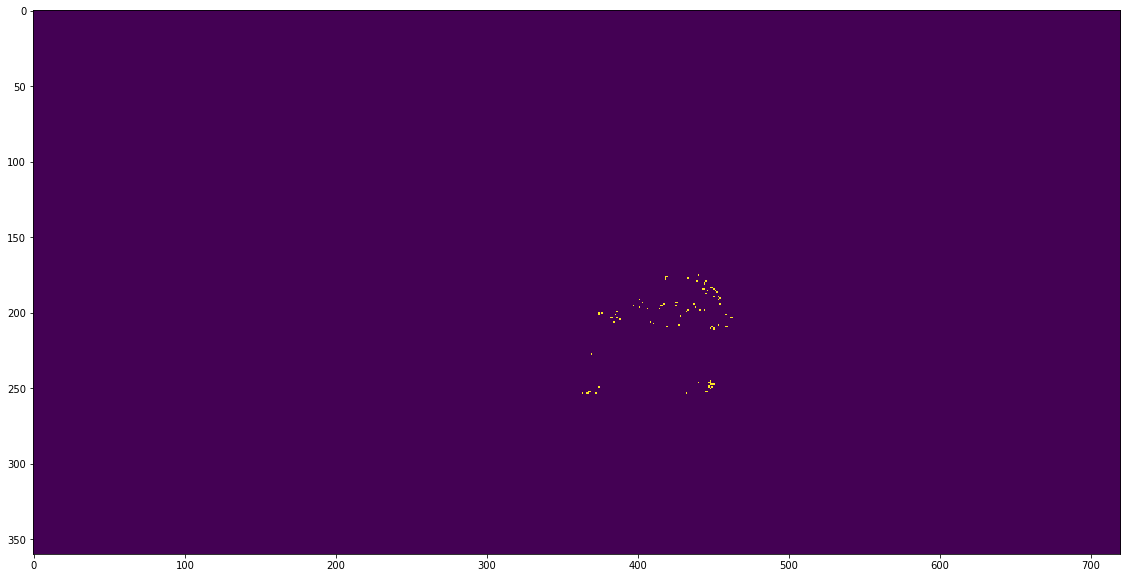

In [32]:
plt.figure(figsize = (50,10))
plt.imshow(test_set[11][0],vmin = 0, vmax = 1)

In [33]:
np.unique(test_set[0][0])

array([0., 1.])

now put this into our random selection.

In [34]:
test_set.shape


(24, 5, 360, 720)

In [35]:
def full_dataset_h5py(image, filename, key_list_prio, key_list_ucdp, chunk_size = 16, draws = 5, min_events = 25, debug = False):
    """ dataset is too large to combine in 12gb of ram - need to combine in h5py
    array. i.e lazy saving as well as lazy loading"""
    
    with h5py.File(filename + ".hdf5", 'w') as f:
        for i in range(11, len(image)-1):
            print(i)
            t1, t2 = random_grid_selection(image, i, min_events = min_events)
            if i == 11:
                # creat h5py file at first step.
                f.create_dataset('predictor', data= t1, maxshape=(None,None, None, None,None)) # compression="gzip", chunks=True, taken out
                f.create_dataset("truth", data= t2, maxshape=(None,None,None))
        
            else:
                f["predictor"].resize((f["predictor"].shape[0] + t1.shape[0]), axis = 0) # expand dataset
                f["truth"].resize((f["truth"].shape[0] + t2.shape[0]), axis = 0)
            
                f["predictor"][-t1.shape[0]:] = t1 # place new data in expanded dataset
                f["truth"][-t2.shape[0]:] = t2
        
        f["predictor"].attrs.create("key_prio", np.string_(key_list_prio))
        f["truth"].attrs.create("key_ucdp", np.string_(key_list_ucdp))
        
        
    
#     f.close()
        

In [36]:
train_set[:100].shape

(100, 5, 360, 720)

In [37]:
test_set.shape

(24, 5, 360, 720)

In [38]:
%pwd

'/rdsgpfs/general/user/gcl15/home'

In [39]:
# a, b = full_dataset_numpy(test)
full_dataset_h5py(train_set, "train_next_event",key_list_prio, key_list_ucdp)
# why does this only work with array > 105???????????
full_dataset_h5py(test_set, "test_next_event",key_list_prio, key_list_ucdp)



11
Image shape is: (276, 5, 360, 720)
(49,)
12
Image shape is: (276, 5, 360, 720)
(84,)
13
Image shape is: (276, 5, 360, 720)
(61,)
14
Image shape is: (276, 5, 360, 720)
(70,)
15
Image shape is: (276, 5, 360, 720)
(76,)
16
Image shape is: (276, 5, 360, 720)
(68,)
17
Image shape is: (276, 5, 360, 720)
(54,)
18
Image shape is: (276, 5, 360, 720)
(56,)
19
Image shape is: (276, 5, 360, 720)
(59,)
20
Image shape is: (276, 5, 360, 720)
(65,)
21
Image shape is: (276, 5, 360, 720)
(56,)
22
Image shape is: (276, 5, 360, 720)
(51,)
23
Image shape is: (276, 5, 360, 720)
(49,)
24
Image shape is: (276, 5, 360, 720)
(68,)
25
Image shape is: (276, 5, 360, 720)
(57,)
26
Image shape is: (276, 5, 360, 720)
(65,)
27
Image shape is: (276, 5, 360, 720)
(60,)
28
Image shape is: (276, 5, 360, 720)
(56,)
29
Image shape is: (276, 5, 360, 720)
(30,)
30
Image shape is: (276, 5, 360, 720)
(37,)
31
Image shape is: (276, 5, 360, 720)
(32,)
32
Image shape is: (276, 5, 360, 720)
(36,)
33
Image shape is: (276, 5, 360,

In [40]:

%pwd
# %cd data

# 


'/rdsgpfs/general/user/gcl15/home'

In [41]:
f = h5py.File("train_next_event.hdf5", 'r')


In [42]:
f['predictor'].shape

(57893, 10, 5, 16, 16)

In [43]:
k = f['predictor'][333]
a = f['truth'][333]


In [44]:
np.unique(k[:,0])

array([0., 1.])

In [45]:
a.shape

(16, 16)

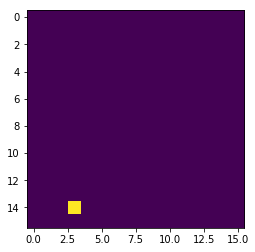

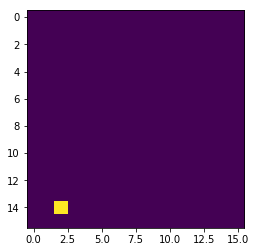

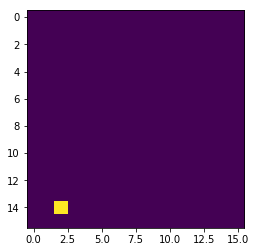

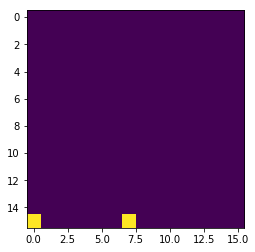

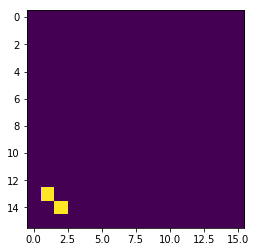

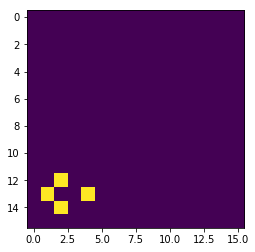

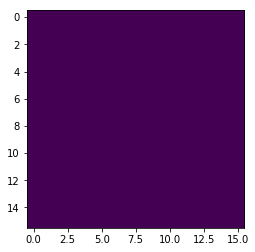

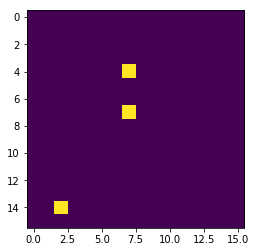

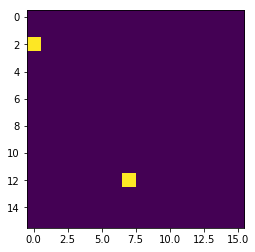

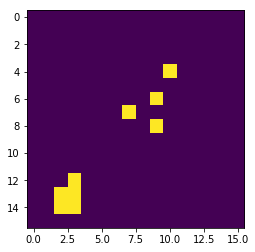

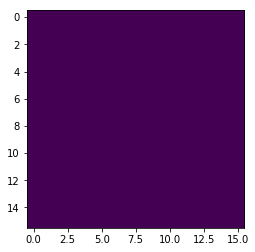

In [46]:
for i in range(10):
    plt.figure()
    plt.imshow(k[i,0])
    
plt.figure()
plt.imshow(a)

In [47]:

val  = k[0:10000,:,0]

In [48]:
# # print(np.average(val))
# # print(np.average(k[10000:20000,:,0]))

# for i in range(7):
#     print(np.std(k[i * 10000:(i+1)*10000, :, 0]))
   

# print(np.std(k[80000:84485, :, 0]))



In [49]:
f['predictor'].shape


(57893, 10, 5, 16, 16)

In [50]:
f['truth'].shape


(57893, 16, 16)

In [51]:
f["predictor"].shape



(57893, 10, 5, 16, 16)

In [52]:
f["predictor"][21000][0][2]

array([[3.241583e+04, 4.238798e+04, 1.306729e+04, 9.216207e+03,
        9.009340e+03, 2.396118e+04, 3.442233e+04, 4.086907e+04,
        4.628775e+04, 2.013035e+04, 6.704871e+04, 3.002618e+05,
        3.363307e+05, 4.028627e+05, 2.822115e+05, 3.566055e+05],
       [5.808011e+04, 3.989859e+04, 2.591515e+04, 1.257617e+04,
        2.910053e+04, 1.926945e+04, 2.299646e+04, 1.098191e+04,
        2.749036e+04, 2.386647e+04, 4.246332e+04, 4.495885e+05,
        5.617256e+05, 3.126451e+05, 1.774272e+05, 2.037623e+05],
       [4.093018e+04, 4.594495e+04, 4.492832e+04, 1.742543e+04,
        2.907948e+04, 2.596789e+04, 6.943363e+04, 1.527858e+04,
        3.747991e+04, 3.748299e+04, 6.581468e+04, 2.306238e+05,
        3.227218e+05, 5.928614e+05, 2.965112e+05, 3.057159e+05],
       [3.558964e+04, 8.351395e+04, 7.275356e+04, 3.100071e+04,
        1.009787e+04, 1.589804e+04, 4.420550e+04, 9.157805e+03,
        2.235657e+04, 9.011832e+04, 9.098925e+04, 1.072629e+05,
        1.755218e+05, 3.775116e+05, 9

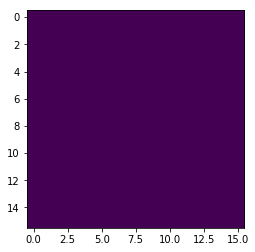

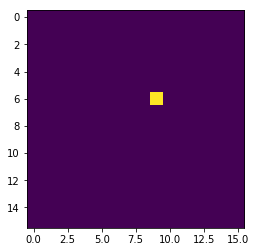

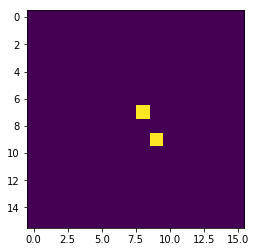

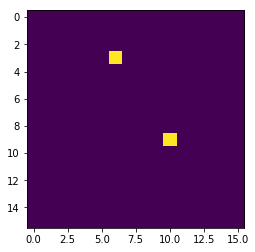

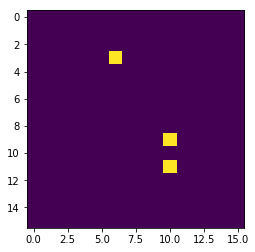

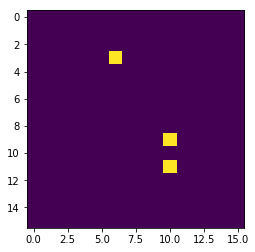

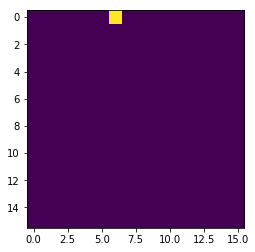

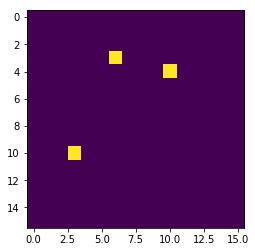

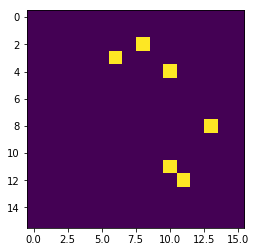

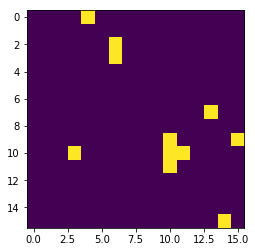

In [53]:
f["predictor"].shape

for i in range(10):
    plt.figure()
    plt.imshow(f["predictor"][21000][i][0])
    

In [54]:
f["predictor"].shape
k = 0
for i in range(248580):
    k +=1
print("done")


done


In [55]:
# len(np.where(f["predictor"][100000][:,0] > 0)[0])
# f["predictor"][100000][:,0]
# plt.imshow(f["predictor"][100000][:,0][0])
len([])

0

In [56]:

def data_set_analysis(dataset):
    dat = np.zeros(len(dataset["predictor"]))
    for i in range(len(dataset["predictor"])):
        dat[i] = len(np.where(f["predictor"][i][:,0] > 0)[0])
        if (i % 1000) == 0:
            print(i)
    return dat

dats = data_set_analysis(f)
np.save("distribution_min_25", dats)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


In [57]:
# np.save("dats_saved", dats)

In [58]:
# np.unique(dats)

In [59]:
# plot = sns.distplot(dats)

In [60]:
# figure = plot.get_figure()

In [61]:
# figure.savefig("min_events_25.pdf")

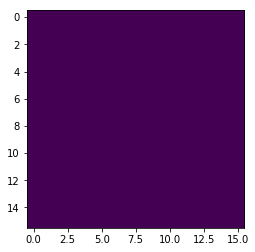

In [62]:
f["predictor"][0][:,0][0].shape
plt.imshow(f["predictor"][1000][:,1][0])

In [63]:
# f.close()

In [64]:
f


<HDF5 file "train_next_event.hdf5" (mode r)>

# AVERAGING FUNCTION

In [65]:
def find_avg_lazy_load(data):
    # file name is name of hdf5 file
#     data = h5py.File(filename, 'r')
    predictor = data["predictor"]
    channel_num = predictor.shape[2]
    avg = np.zeros(channel_num)
    std = np.zeros_like(avg)
    for i in range(channel_num):
        # batching as cant fit into ram
        
        batch_avg = 0
        batch_std = 0
        for j in range(5):
            batch_avg += np.average(predictor[j * 10000: (j+1)*10000,:,i])
            print(batch_avg)
            batch_std += np.std(predictor[j * 10000: (j+1)*10000,:,i])
            
        batch_avg += np.average(predictor[50000: 52109,:,i])
        batch_std += np.std(predictor[50000: 52109,:,i])
        
        batch_avg /= 6
        batch_std /= 6
        
        avg[i] = batch_avg
        std[i] = batch_std
        
        
    return avg, std


In [66]:
f['predictor'].shape


(57893, 10, 5, 16, 16)

In [67]:


avg, std = find_avg_lazy_load(f)

0.02500140625
0.0519103125
0.07864093750000001
0.10447097656250001
0.130019921875
0.99084953125
6.76732375
7.6818317968750005
8.4634739453125
8.9387216796875
82102.27498162742
177156.1845286545
271684.76315582625
401743.44630341686
545550.969492451
341.90741936654575
797.474067863662
1306.3378960846885
1834.6395652158249
2352.3705865939164
572.9642360207921
1324.7907505978774
2174.8150473371466
2885.970630509137
3490.4040311670215


In [68]:
np.save("next_event_avg", avg)

In [69]:
np.save("next_event_std", std)

In [70]:
f['predictor'].shape

(57893, 10, 5, 16, 16)

In [71]:
f.close()

In [72]:
%pwd

'/rdsgpfs/general/user/gcl15/home'

In [73]:
f.close()


In [74]:
# avg, std = find_avg_lazy_load("data_prio_run_test4.hdf5")